In [53]:
import graphlab as gl
import numpy as np
import graphlab.aggregate as agg
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline
gl.canvas.set_target('ipynb')

### Data Exploration  
Let's start by loading train dataset into SFrames from graphlab and do the join

In [4]:
featuressf = gl.SFrame.read_csv("train_features_2013-03-07.csv", verbose=False)
salariessf = gl.SFrame.read_csv("train_salaries_2013-03-07.csv", verbose=False)

In [6]:
data = featuressf.join(salariessf,on="jobId",how="inner")

### Let's look at the summary of all variable

In [8]:
data.show()

### We have mostly categorical variables, which will have to be encoded (dummy encoded) for the regression problem. Finally, the distribution for salary seems to have outliers. Let's look at it closer

Text(0.5,1,u'Salary histogram')

Text(0,0.5,u'Count')

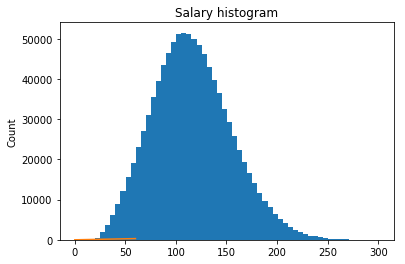

In [10]:
n, bins, patches = plt.hist(list(data["salary"]),bins=60)
plt.plot(bins)
plt.title("Salary histogram")
plt.ylabel('Count')
plt.show()

### The distribution is greatly skewed. Let's work with it with several regression models and evaluate the resulting trained model
* Linear regression
* Boosted Decision Trees regression
* Random Forest Regression


### But first, let's split data into train and test set, 80% and 20% respectively)

In [11]:
# Make a train-test split
train_data, test_data = data.random_split(0.8,seed=1234)


# Linear regression

In [12]:
# Create a model with categorical features.
model_lr = gl.linear_regression.create(train_data, target='salary',
                                    features = ['yearsExperience',
                                                'milesFromMetropolis',
                                                'industry',
                                                'major',
                                                'degree',
                                                'companyId',
                                                 'jobType'],
                                feature_rescaling = False, verbose=False)

# Number of feature columns
print("Number of features          : %s" % model_lr['num_features'])

# Number of features (including expanded lists and dictionaries)
print("Number of unpacked features : %s" % model_lr['num_unpacked_features'])

# Number of coefficients in the model
print("Number of coefficients      : %s" % model_lr['num_coefficients'])

# A coefficient is included for each category
print(model_lr['coefficients'].print_rows(30))

Number of features          : 7
Number of unpacked features : 7
Number of coefficients      : 90
+---------------------+-------------+-------------------+-------------------+
|         name        |    index    |       value       |       stderr      |
+---------------------+-------------+-------------------+-------------------+
|     (intercept)     |     None    |    141.09660795   |   0.226589172412  |
|   yearsExperience   |     None    |   2.01053266846   |  0.00311509431142 |
| milesFromMetropolis |     None    |  -0.399469750936  | 0.000778243971799 |
|       industry      |     AUTO    |   -6.24319228934  |  0.0840926770595  |
|       industry      |  EDUCATION  |   -16.2195941917  |  0.0841332150531  |
|       industry      |     OIL     |   15.0532471095   |  0.0841197695342  |
|       industry      |   FINANCE   |   14.9050358559   |  0.0841927703472  |
|       industry      |   SERVICE   |   -11.2315981667  |  0.0841681623045  |
|       industry      |     WEB     |   5.887

### Evaluate performance with the test set

In [14]:
# Save predictions to an SFrame (class and corresponding class-probabilities)
predictions = model_lr.predict(test_data)

# Evaluate the model and save the results into a dictionary
results = model_lr.evaluate(test_data)

print " Evaluation metrics: ", results

 Evaluation metrics:  {'max_error': 180.46847502955546, 'rmse': 19.638006296230873}


## Boosted Decision Trees Regression

In [29]:
model_bt = gl.boosted_trees_regression.create(train_data, target='salary',
                                           features = [
                                                'milesFromMetropolis',
                                                'yearsExperience',
                                                'industry',
                                                'major',
                                                'degree',
                                                'companyId',
                                                 'jobType'],
                                           max_iterations=40,
                                           max_depth =  6, verbose=False)



In [30]:
# Save predictions to an SArray
predictions_bt = model_bt.predict(test_data)

# Evaluate the model and save the results into a dictionary
results_bt = model_bt.evaluate(test_data)
print " Evaluation metrics: ", results_bt

 Evaluation metrics:  {'max_error': 187.51661682128906, 'rmse': 19.056504520903147}


## Random Forest Regression

In [31]:
# Create a model.
model_rf = gl.random_forest_regression.create(train_data, target='salary',
                                           features = ['yearsExperience',
                                                'milesFromMetropolis',
                                                'industry',
                                                'major',
                                                'degree',
                                                'companyId',
                                                 'jobType'],
                                           max_iterations=100,
                                           max_depth =  6, verbose=False)


In [32]:
# Save predictions to an SArray
predictions_rf = model_rf.predict(test_data)

# Evaluate the model and save the results into a dictionary
results_rf = model_rf.evaluate(test_data)
print " Evaluation metrics: ", results_rf

 Evaluation metrics:  {'max_error': 154.817626953125, 'rmse': 24.312961312295222}


## Important features

In [261]:
print(model_lr['coefficients'].print_rows(30))
print(model_bt.get_feature_importance().print_rows(94))
print(model_rf.get_feature_importance().print_rows(33))

+---------------------+-------------+-------------------+-------------------+
|         name        |    index    |       value       |       stderr      |
+---------------------+-------------+-------------------+-------------------+
|     (intercept)     |     None    |    141.09660795   |   0.226589172412  |
|   yearsExperience   |     None    |   2.01053266846   |  0.00311509431142 |
| milesFromMetropolis |     None    |  -0.399469750936  | 0.000778243971799 |
|       industry      |     AUTO    |   -6.24319228934  |  0.0840926770595  |
|       industry      |  EDUCATION  |   -16.2195941917  |  0.0841332150531  |
|       industry      |     OIL     |   15.0532471095   |  0.0841197695342  |
|       industry      |   FINANCE   |   14.9050358559   |  0.0841927703472  |
|       industry      |   SERVICE   |   -11.2315981667  |  0.0841681623045  |
|       industry      |     WEB     |   5.88753320809   |  0.0841510518621  |
|        major        |  CHEMISTRY  |   -4.00834165234  |   0.13

## Could Extreme Gradient Boosting work better?
Let's try it, but now using pandas

In [46]:
datap = data.to_dataframe()
datap.set_index("jobId",inplace=True)

In [47]:
datap.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## Now we have to do the dummy encoding and pandas offers that possibility really nicely and quick

In [197]:
train_df = pd.get_dummies( train_data.to_dataframe(), columns =["industry","jobType","degree","major","companyId"] )
test_df = pd.get_dummies( test_data.to_dataframe(), columns =["industry","jobType","degree","major","companyId"] )

In [198]:
#data_with_dummies.head()

In [199]:
train_y = train_df["salary"].as_matrix()
train_X = train_df.drop(['jobId','salary'], axis=1).as_matrix()
test_y  = test_df["salary"].as_matrix()
test_X = test_df.drop(['jobId','salary'],axis=1).as_matrix()

## Now let's do the regression using the XGBRegresson from xgboost

In [90]:
my_model = XGBRegressor(max_depth=5)
my_model.fit(train_X, train_y,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Evaluate performance as the other algorithms and return residuals, we might want to take a deeper look on how they behave

In [91]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
    
def print_and_return_residuals(X,y,model):
    predictions = model.predict(X)
    print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y)))
    print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(predictions, y))))
    print("Max error: " + str(np.max(np.subtract(predictions,y).max())))
    return np.subtract(predictions,y)
    

In [92]:
print("Test results: ")
test_residuals = print_and_return_residuals(test_X,test_y,my_model)
print("Training results: ")
train_residuals = print_and_return_residuals(train_X,train_y,my_model)


Test results: 
Mean Absolute Error : 15.3893866942
Root Mean Squared Error : 18.9759171966
Max error: 184.299194336
Training results: 
Mean Absolute Error : 15.3522845868
Root Mean Squared Error : 18.9066518366
Max error: 138.330810547


## The results are very similar to the ones found in the previous attempts. The regression model seems to have a hard time capturing the long tail that the salaries distribution has. Let's look at the residuals

## It is not obvious to make conclusions yet, let's look at the residuals 

Text(0.5,1,u'Test residuals XGBoost')

Text(0,0.5,u'Count')

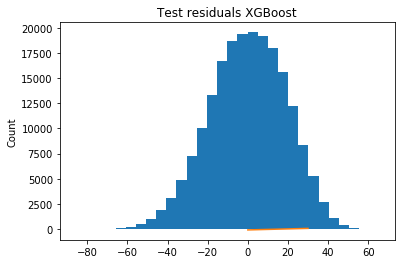

In [71]:
n, bins, patches = plt.hist(test_residuals,bins=30)
plt.plot(bins)
plt.title("Test residuals XGBoost")
plt.ylabel('Count')
plt.show()

Text(0.5,1,u'Train residuals XGBoost')

Text(0,0.5,u'Count')

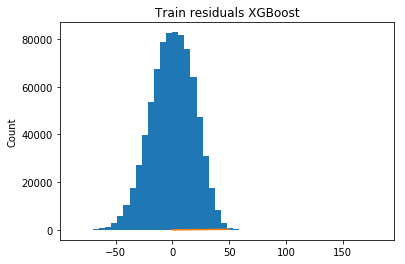

In [82]:
n, bins, patches = plt.hist(train_residuals,bins=50)
plt.plot(bins)
plt.title("Train residuals XGBoost")
plt.ylabel('Count')
plt.show()

In [70]:
residuals_bt = predictions_bt - test_data["salary"]
residuals_rf = predictions_rf - test_data["salary"]

Text(0.5,1,u'Test residuals Boosted Tree')

Text(0,0.5,u'Count')

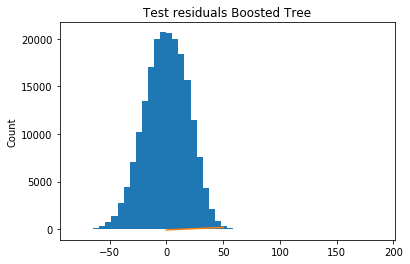

In [73]:
n, bins, patches = plt.hist(residuals_bt,bins=50)
plt.plot(bins)
plt.title("Test residuals Boosted Tree")
plt.ylabel('Count')
plt.show()

Text(0.5,1,u'Test residuals Random Forest')

Text(0,0.5,u'Count')

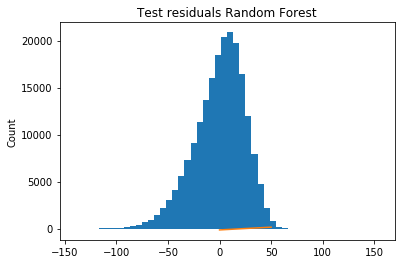

In [74]:
n, bins, patches = plt.hist(residuals_rf,bins=50)
plt.plot(bins)
plt.title("Test residuals Random Forest")
plt.ylabel('Count')
plt.show()

In [81]:
(residuals_bt-residuals_rf).max()

78.31996154785156

## In this first attempt to predict the salary, we noticed that only two regression models seem "fairly" well behaved in terms of residuals. Those are Boosted Decision Trees and XGBoost. We have residual outliers from salaries that seem hard to predict by any of the two regression models. We might be able to improve the model if we use the first modeling pass on XGBoost regression and remove outliers. Let's keep data within 2.5 standard deviations from zero in the residuals (on the

In [248]:
train_data.shape
train_X.shape
train_y.shape

(800067, 10)

(800067, 94)

(800067,)

In [249]:
residuals_train_bt = model_bt.predict(train_data)
residuals_train_xbg = my_model.predict(train_X)

residuals_train_bt = residuals_train_bt - train_data["salary"]
residuals_train_xbg = residuals_train_xbg - train_y

In [250]:
residuals_train_bt.mean()
residuals_train_bt.std()

-0.005456341775577892

18.952419422833977

In [251]:
np.mean(residuals_train_xbg)
np.std(residuals_train_xbg)

-0.0030882984052366803

18.906651584342786

In [252]:
train_data["xgb_residuals"]=np.abs(residuals_train_xbg)

In [253]:
train_data[train_data["xgb_residuals"] < (2.5*np.std(residuals_train_xbg))].shape

(792831, 10)

In [254]:
train_data_clean = train_data[train_data["xgb_residuals"] < (2.5*np.std(residuals_train_xbg))]

In [255]:
train_data_clean.remove_column("xgb_residuals")

jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68
JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24,30
JOB1362684407698,COMP7,CEO,MASTERS,PHYSICS,EDUCATION,7,79
JOB1362684407699,COMP4,JUNIOR,NONE,NONE,OIL,8,29
JOB1362684407700,COMP54,JUNIOR,MASTERS,MATH,FINANCE,21,26


In [256]:
train_data_clean_df = pd.get_dummies( train_data_clean.to_dataframe(), columns =["industry","jobType","degree","major","companyId"] )

In [257]:
train_data_clean_df.head()

,jobId,yearsExperience,milesFromMetropolis,salary,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,...,companyId_COMP57,companyId_COMP58,companyId_COMP59,companyId_COMP6,companyId_COMP60,companyId_COMP61,companyId_COMP62,companyId_COMP7,companyId_COMP8,companyId_COMP9
0,JOB1362684407687,10,83,130,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JOB1362684407690,8,17,142,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JOB1362684407693,23,24,178,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JOB1362684407694,9,70,73,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407695,1,54,31,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
residuals_bt.mean()
residuals_bt.std()

-0.019865644191396036

19.05649416633039

In [259]:
train_clean_y = train_data_clean_df["salary"].as_matrix()
train_clean_X = train_data_clean_df.drop(['jobId','salary'], axis=1).as_matrix()

In [260]:
my_clean_model = XGBRegressor(max_depth=5)
my_clean_model.fit(train_clean_X, train_clean_y,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [247]:
print("Test results: ")
test_clean_residuals = print_and_return_residuals(test_X,test_y,my_clean_model)
print("Training results: ")
train_clean_residuals = print_and_return_residuals(train_clean_X,train_clean_y,my_clean_model)


Test results: 
Mean Absolute Error : 15.4132413213
Root Mean Squared Error : 19.049596095
Max error: 182.079467773
Training results: 
Mean Absolute Error : 14.1704110443
Root Mean Squared Error : 17.0713847596
Max error: 41.9108352661


Text(0.5,1,u'Train residuals Clean Data')

Text(0,0.5,u'Count')

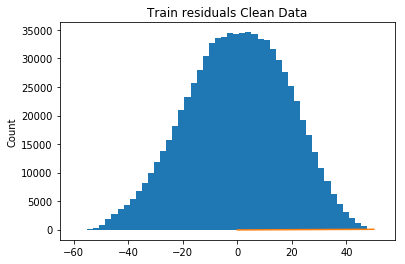

In [230]:
n, bins, patches = plt.hist(train_clean_residuals,bins=50)
plt.plot(bins)
plt.title("Train residuals Clean Data")
plt.ylabel('Count')
plt.show()

In [231]:
test_f_sf = gl.SFrame.read_csv("test_features_2013-03-07.csv", verbose=False)
test_f_df = pd.get_dummies( test_f_sf.to_dataframe(), columns =["industry","jobType","degree","major","companyId"] )

In [232]:
test_f_X = test_f_df.drop(['jobId'], axis=1).as_matrix()

In [233]:
predictionsf_xgb = my_clean_model.predict(test_f_X)

In [234]:
test_f_sf["salary"]=predictionsf_xgb
final_results = test_f_sf[["jobId","salary"]]
final_results.save("test_salaries.csv",format='csv')

## Other exploratory work

## Could we build an ensemble 

In [94]:
test_data.shape
test_df.shape
test_X.shape
#train_X.shape

(199933, 9)

(199933, 96)

(199933, 94)

In [123]:
predictions_lr = model_lr.predict(train_data)
predictions_bt = model_bt.predict(train_data)
predictions_rf = model_rf.predict(train_data)
predictions_xgb = my_model.predict(train_X)
salary_train = train_data["salary"]

In [124]:
train2_data = gl.SFrame({'predictions_lr':predictions_lr,
             'predictions_bt':predictions_bt,
             'predictions_rf':predictions_rf,
             'predictions_xgb':predictions_xgb,
             'salary':salary_train})

In [126]:
predictions_lr = model_lr.predict(test_data)
predictions_bt = model_bt.predict(test_data)
predictions_rf = model_rf.predict(test_data)
predictions_xgb = my_model.predict(test_X)
salary_test = test_data["salary"]

In [127]:
test2_data = gl.SFrame({'predictions_lr':predictions_lr,
             'predictions_bt':predictions_bt,
             'predictions_rf':predictions_rf,
             'predictions_xgb':predictions_xgb,
             'salary':salary_test})

In [128]:
test2_data.shape
train2_data.shape

(199933, 5)

(800067, 5)

In [111]:
train2_data.print_rows(100)

+-----------------+----------------+----------------+----------------+-------------+
| predictions_xgb | predictions_bt | predictions_lr | predictions_rf | salary_test |
+-----------------+----------------+----------------+----------------+-------------+
|  128.368911743  | 133.543762207  | 128.045945307  | 126.634284973  |     130     |
|   124.85874939  | 121.404953003  | 125.376280014  | 118.476020813  |     142     |
|  157.780914307  | 161.369873047  | 153.327950444  | 144.897979736  |     178     |
|  67.4269104004  | 68.6509857178  | 66.3859755265  | 80.0061721802  |      73     |
|  31.7900905609  | 30.0453262329  | 32.1432489256  | 44.9831390381  |      31     |
|  120.503395081  | 120.380378723  | 123.142997856  | 135.536651611  |     104     |
|   106.2395401   | 106.625579834  | 104.159144275  | 98.0351257324  |     102     |
|  115.299079895  | 117.920906067  | 114.563668412  | 123.743011475  |     144     |
|  92.8411407471  | 91.8725662231  | 96.6978797517  | 87.56645202

In [130]:
model_final = gl.linear_regression.create(train2_data, target='salary',
                                           features = ['predictions_xgb',
                                                     'predictions_bt',
                                                    'predictions_lr',
                                                    'predictions_rf'],
                                               feature_rescaling = False,
                                          verbose=False)


In [134]:
predictions_final = model_final.predict(test2_data)
results_final = model_final.evaluate(test2_data)
results_final

{'max_error': 186.87702756846662, 'rmse': 18.93483484159112}

In [133]:
print model_final["coefficients"]

+-----------------+-------+------------------+------------------+
|       name      | index |      value       |      stderr      |
+-----------------+-------+------------------+------------------+
|   (intercept)   |  None |  0.262170083782  |  0.108672101254  |
| predictions_xgb |  None |  0.663616490351  | 0.00815192284177 |
|  predictions_bt |  None |  0.382684134342  | 0.00700550091249 |
|  predictions_lr |  None | 0.0027143579353  | 0.0041285189256  |
|  predictions_rf |  None | -0.0512772183084 | 0.00210969766726 |
+-----------------+-------+------------------+------------------+
[5 rows x 4 columns]



In [135]:
residuals_final = predictions_final - test2_data["salary"]

Text(0.5,1,u'Test residuals Ensemble')

Text(0,0.5,u'Count')

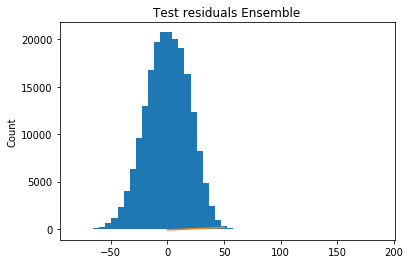

In [136]:
n, bins, patches = plt.hist(residuals_final,bins=50)
plt.plot(bins)
plt.title("Test residuals Ensemble")
plt.ylabel('Count')
plt.show()

## Let's run it on our test data set

In [174]:
test_f_sf = gl.SFrame.read_csv("test_features_2013-03-07.csv", verbose=False)
test_f_df = pd.get_dummies( test_f_sf.to_dataframe(), columns =["industry","jobType","degree","major","companyId"] )

In [175]:
test_f_sf.shape
test_f_df.shape

(1000000, 8)

(1000000, 95)

In [177]:
test_f_X = test_f_df.drop(['jobId'], axis=1).as_matrix()

In [178]:
predictionsf_lr = model_lr.predict(test_f_sf)
predictionsf_bt = model_bt.predict(test_f_sf)
predictionsf_rf = model_rf.predict(test_f_sf)
predictionsf_xgb = my_model.predict(test_f_X)
#salary_train = train_data["salary"]

In [183]:
len(predictionsf_lr)
len(predictionsf_xgb)

1000000

1000000

In [182]:
testf2_sf = gl.SFrame({'predictions_lr':predictionsf_lr,
             'predictions_bt':predictionsf_bt,
             'predictions_rf':predictionsf_rf,
             'predictions_xgb':predictionsf_xgb})

In [184]:
testf2_sf.shape

(1000000, 4)

In [185]:
predictionsf_final = model_final.predict(testf2_sf)

In [186]:
test_f_sf["salary"]=predictionsf_final

final_results = test_f_sf[["jobId","salary"]]

final_results.save("test_salaries.csv",format='csv')